In [13]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [15]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [16]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [17]:
dataset = SunImageDataset(csv_file="/content/dataset_full_2024_with_cr_3days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size-24]
k_fold_2_indices = indices[fold_size+24:(2*fold_size)-24]
k_fold_3_indices = indices[(2*fold_size)+24:(3*fold_size)-24]
k_fold_4_indices = indices[(3*fold_size)+24:(4*fold_size)-24]
k_fold_5_indices = indices[(4*fold_size)+24:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_2024_with_cr_3days.csv")
kp_dates_list = kp_dates["date"].tolist()

1869
1845
1845
1845
1872


In [18]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_2024_with_cr_3days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

511
621
570
293
718


In [19]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

In [20]:
torch.cuda.empty_cache()

In [21]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [22]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.979208833474995


Validation Progress: Epoch: 1:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.7579129880127986


Training Progress: Epoch: 2:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.4605201809261545


Validation Progress: Epoch: 2:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.942580157490497


Training Progress: Epoch: 3:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.1583665595037655


Validation Progress: Epoch: 3:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.725173069736024


Training Progress: Epoch: 4:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.8604071583069436


Validation Progress: Epoch: 4:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.8815013193652372


Training Progress: Epoch: 5:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.6831645483558291


Validation Progress: Epoch: 5:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.261803522925789


Training Progress: Epoch: 6:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.5451665278706452


Validation Progress: Epoch: 6:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.003841997054468


Training Progress: Epoch: 7:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.44184675829591935


Validation Progress: Epoch: 7:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.0682438341246416


Training Progress: Epoch: 8:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.3744198016333596


Validation Progress: Epoch: 8:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.2047655864738247


Training Progress: Epoch: 9:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.33142907398150173


Validation Progress: Epoch: 9:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.1026891385241195


Training Progress: Epoch: 10:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.2849789887443829


Validation Progress: Epoch: 10:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.159671041857262


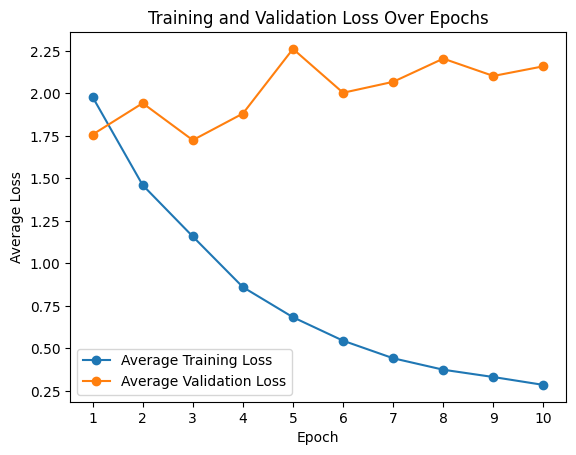

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/935 [00:00<?, ?it/s]

Average test loss: 2.1597
RMSE: 1.4696
MSE: 2.1608
MAE: 1.1935
R²: -0.1912
R: 0.2456
True Skill Score: 0.1581
Accuracy: 0.6699
Precision: 0.4070
Recall: 0.4540
F1 Score: 0.4292


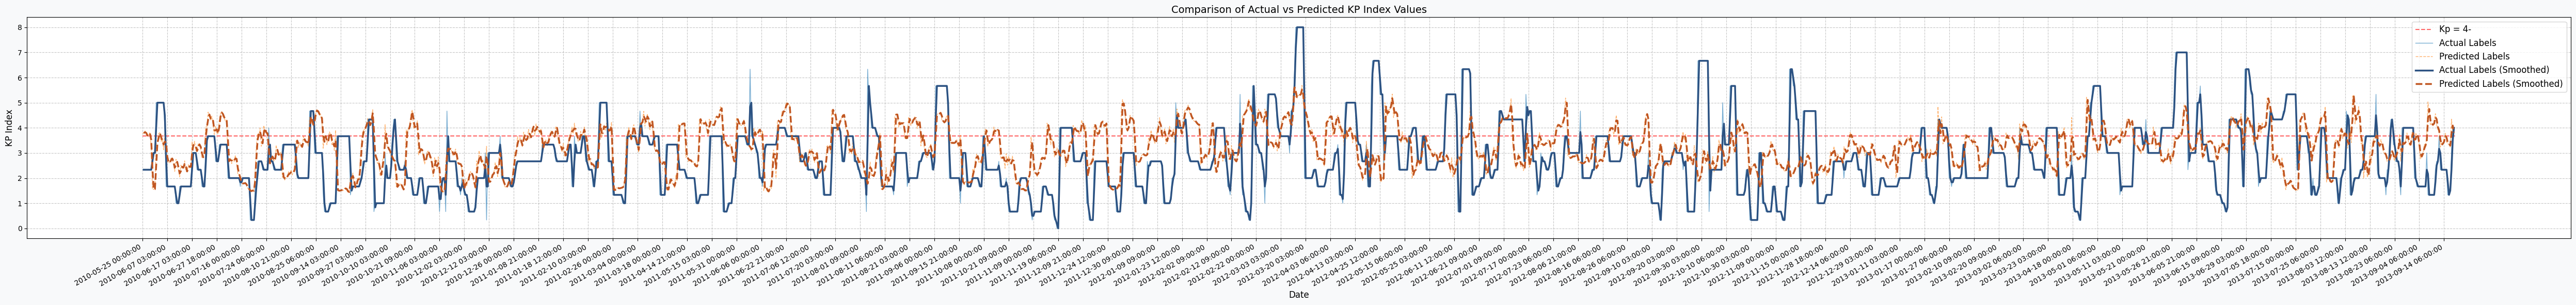

[np.float32(3.796875), np.float32(3.78125), np.float32(3.875), np.float32(3.71875), np.float32(3.671875), np.float32(3.71875), np.float32(3.828125), np.float32(3.21875), np.float32(1.546875), np.float32(1.5546875), np.float32(1.5703125), np.float32(3.359375), np.float32(3.4375), np.float32(3.765625), np.float32(3.8125), np.float32(3.453125), np.float32(3.546875), np.float32(3.125), np.float32(3.78125), np.float32(3.015625), np.float32(2.6875), np.float32(2.59375), np.float32(2.625), np.float32(2.796875), np.float32(2.765625), np.float32(2.5625), np.float32(2.265625), np.float32(2.75), np.float32(2.546875), np.float32(2.328125), np.float32(2.046875), np.float32(2.515625), np.float32(2.390625), np.float32(2.4375), np.float32(2.6875), np.float32(2.28125), np.float32(2.25), np.float32(2.53125), np.float32(2.40625), np.float32(2.484375), np.float32(3.4375), np.float32(3.1875), np.float32(3.46875), np.float32(3.109375), np.float32(3.046875), np.float32(3.375), np.float32(3.3125), np.float32(

Testing Progress:   0%|          | 0/256 [00:00<?, ?it/s]

Average test loss: 2.7421
RMSE: 1.6559
MSE: 2.7474
MAE: 1.2917
R²: -1.8275
R: 0.0051


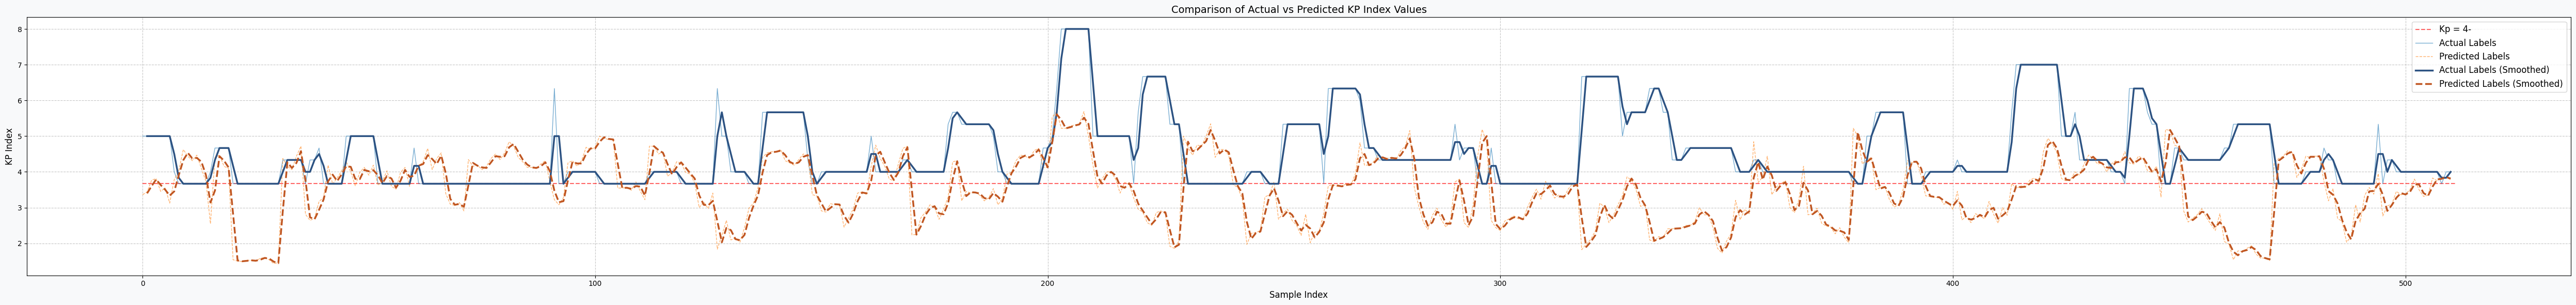

[np.float32(3.359375), np.float32(3.4375), np.float32(3.765625), np.float32(3.8125), np.float32(3.453125), np.float32(3.546875), np.float32(3.125), np.float32(3.78125), np.float32(4.03125), np.float32(4.625), np.float32(4.4375), np.float32(4.3125), np.float32(4.46875), np.float32(4.09375), np.float32(3.734375), np.float32(2.546875), np.float32(4.40625), np.float32(4.46875), np.float32(4.15625), np.float32(4.09375), np.float32(1.5390625), np.float32(1.5), np.float32(1.4921875), np.float32(1.5234375), np.float32(1.5234375), np.float32(1.5), np.float32(1.578125), np.float32(1.6015625), np.float32(1.5390625), np.float32(1.4296875), np.float32(1.4609375), np.float32(4.375), np.float32(4.15625), np.float32(4.0625), np.float32(4.4375), np.float32(4.71875), np.float32(2.8125), np.float32(2.640625), np.float32(2.703125), np.float32(3.171875), np.float32(3.28125), np.float32(4.1875), np.float32(3.65625), np.float32(3.828125), np.float32(4.03125), np.float32(4.28125), np.float32(4.0), np.float32(

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.9189834578797953


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.8056616938336452


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.391215006078193


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.029841813075509


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.029031309980589


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.445723303149286


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.7711464175760226


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9443016115274332


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6023950665596773


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.1908015473648645


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4991282226774186


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0794707982136122


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4084748198389173


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0156158091787293


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3470465238146178


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.2168938560369207


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3074988479444725


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0736571028266173


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2642402414468591


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.2650896539301297


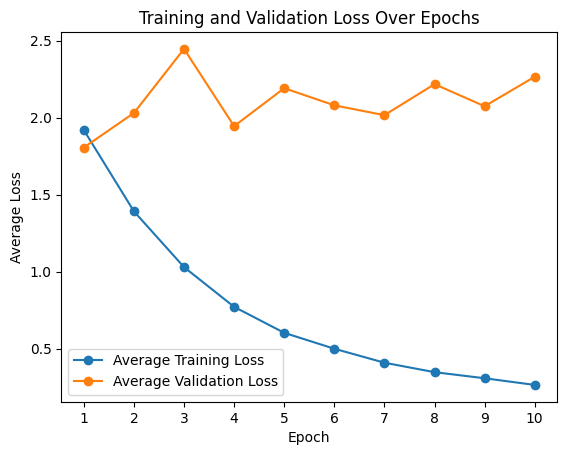

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 2.2651
RMSE: 1.5050
MSE: 2.2646
MAE: 1.1899
R²: -0.2510
R: 0.1905
True Skill Score: 0.2370
Accuracy: 0.6325
Precision: 0.4323
Recall: 0.2931
F1 Score: 0.3493


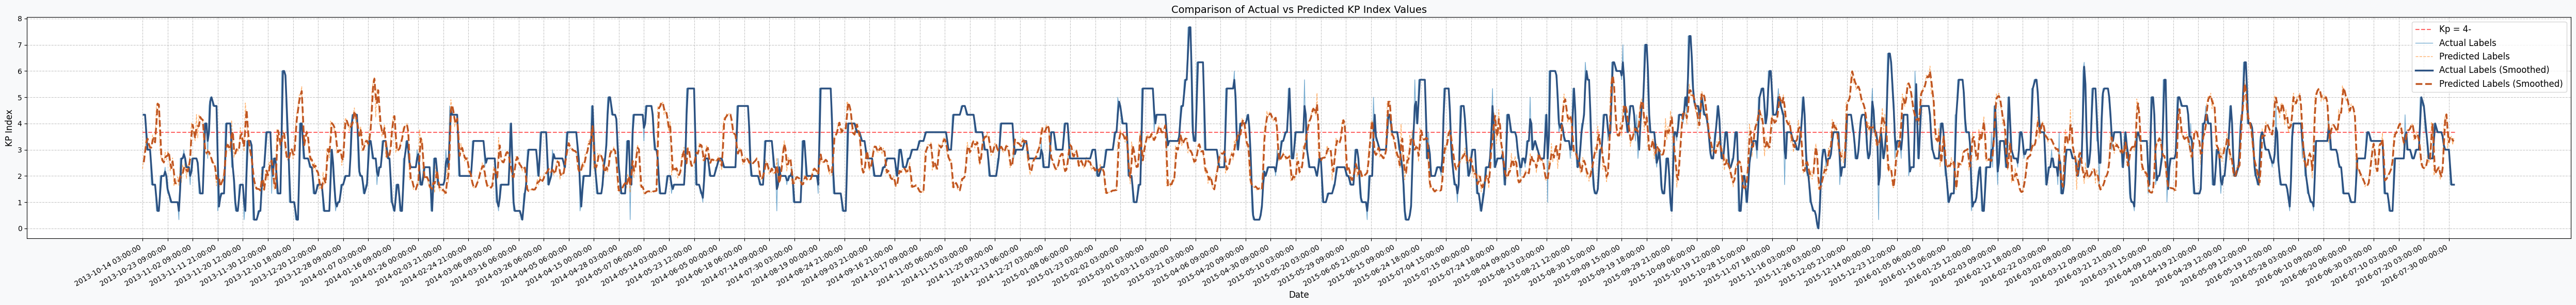

[np.float32(2.265625), np.float32(2.78125), np.float32(3.015625), np.float32(3.546875), np.float32(3.296875), np.float32(3.140625), np.float32(3.015625), np.float32(3.140625), np.float32(3.5625), np.float32(3.328125), np.float32(3.234375), np.float32(4.6875), np.float32(4.8125), np.float32(4.625), np.float32(2.953125), np.float32(2.609375), np.float32(2.546875), np.float32(2.484375), np.float32(2.90625), np.float32(2.609375), np.float32(2.921875), np.float32(2.890625), np.float32(2.171875), np.float32(2.421875), np.float32(2.6875), np.float32(1.609375), np.float32(1.8203125), np.float32(1.6796875), np.float32(1.9609375), np.float32(1.640625), np.float32(2.3125), np.float32(1.75), np.float32(2.421875), np.float32(2.171875), np.float32(2.515625), np.float32(1.90625), np.float32(2.4375), np.float32(2.296875), np.float32(3.03125), np.float32(4.03125), np.float32(3.875), np.float32(3.53125), np.float32(3.34375), np.float32(4.34375), np.float32(3.453125), np.float32(4.34375), np.float32(4.15

Testing Progress:   0%|          | 0/311 [00:00<?, ?it/s]

Average test loss: 3.1701
RMSE: 1.7805
MSE: 3.1718
MAE: 1.4467
R²: -3.6214
R: 0.0547


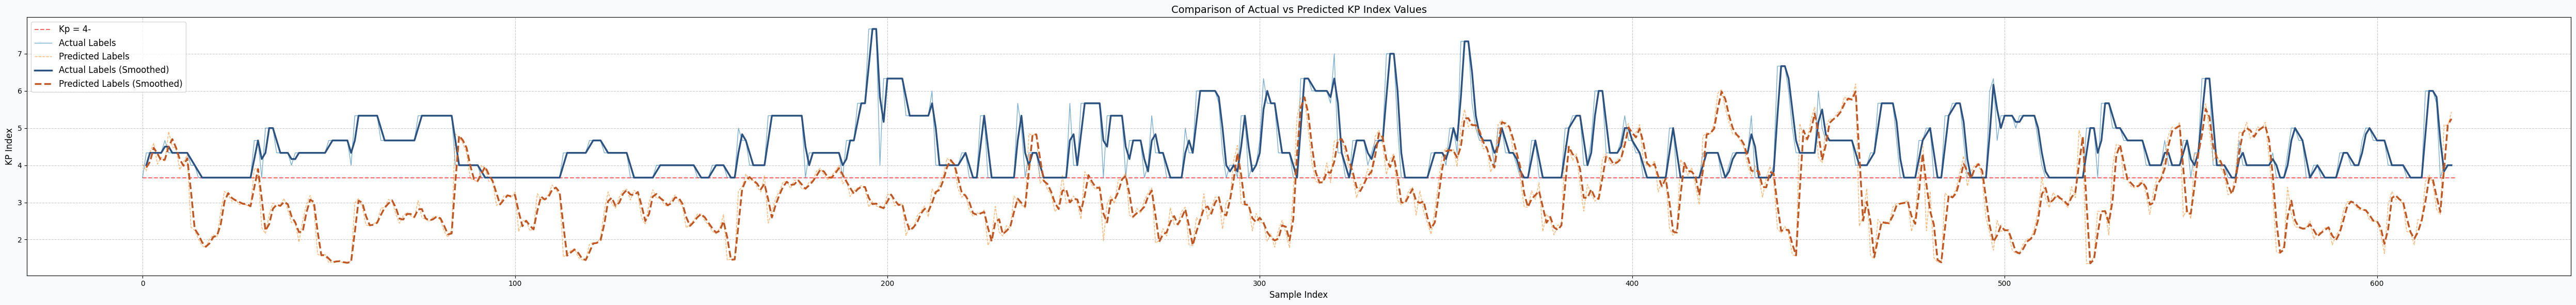

[np.float32(4.03125), np.float32(3.84375), np.float32(4.34375), np.float32(4.59375), np.float32(4.03125), np.float32(4.21875), np.float32(4.09375), np.float32(4.90625), np.float32(4.5), np.float32(4.4375), np.float32(3.875), np.float32(4.09375), np.float32(4.28125), np.float32(2.328125), np.float32(2.25), np.float32(2.015625), np.float32(1.8359375), np.float32(1.78125), np.float32(2.015625), np.float32(2.125), np.float32(2.078125), np.float32(2.75), np.float32(3.296875), np.float32(3.203125), np.float32(3.03125), np.float32(3.078125), np.float32(2.9375), np.float32(2.984375), np.float32(2.921875), np.float32(2.875), np.float32(3.921875), np.float32(3.875), np.float32(2.328125), np.float32(2.15625), np.float32(2.671875), np.float32(2.984375), np.float32(2.890625), np.float32(2.921875), np.float32(3.109375), np.float32(2.796875), np.float32(2.453125), np.float32(2.46875), np.float32(1.9296875), np.float32(2.5), np.float32(2.953125), np.float32(3.1875), np.float32(2.84375), np.float32(1.6

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.973979590218429


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.7478914351479098


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.5249982116081897


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2404502951634766


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.1801713795378421


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.548982499141278


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.9199215562753923


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2692225242629251


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6447988878681269


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.382771539671073


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5205708149512783


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3690631217410942


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.41005544956541734


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4867784026577586


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3446110276829021


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3628771530911192


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2936565131993187


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.312737061648795


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.25764394217898434


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2971764836818758


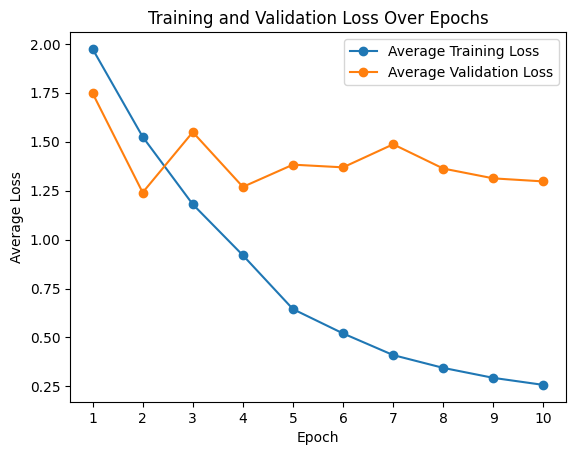

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.2972
RMSE: 1.1389
MSE: 1.2979
MAE: 0.8854
R²: 0.2183
R: 0.4698
True Skill Score: 0.5810
Accuracy: 0.7312
Precision: 0.6492
Recall: 0.2825
F1 Score: 0.3936


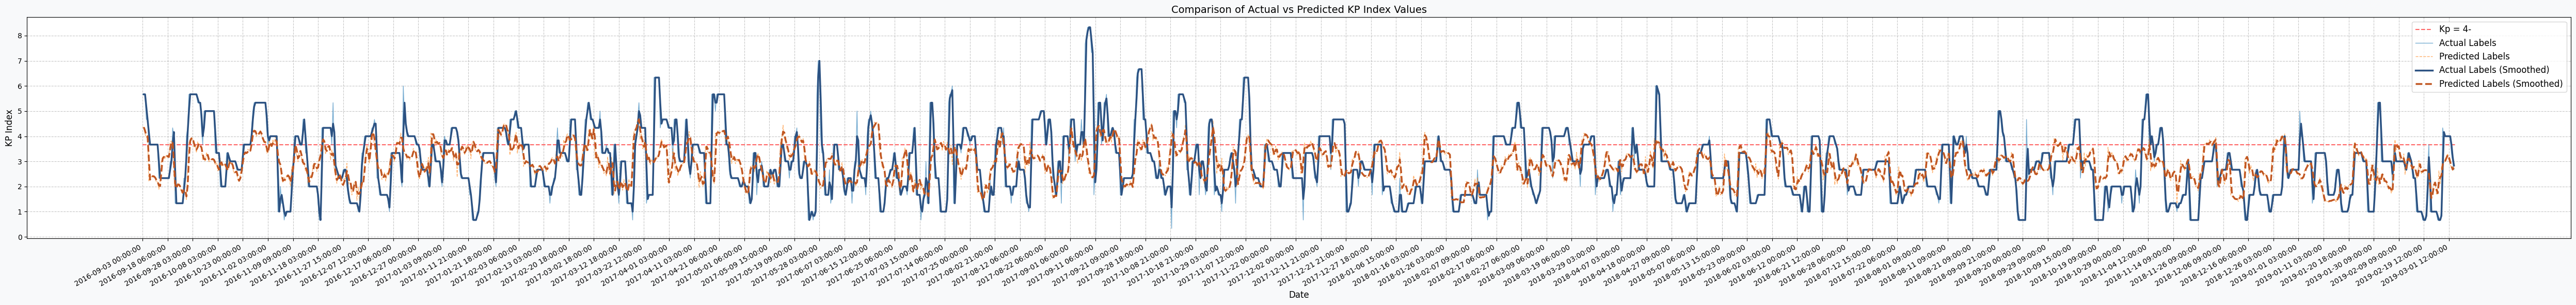

[np.float32(4.375), np.float32(4.34375), np.float32(4.09375), np.float32(3.953125), np.float32(4.03125), np.float32(2.203125), np.float32(2.34375), np.float32(2.375), np.float32(2.4375), np.float32(2.375), np.float32(2.34375), np.float32(2.1875), np.float32(2.203125), np.float32(1.890625), np.float32(2.140625), np.float32(3.015625), np.float32(3.1875), np.float32(3.171875), np.float32(3.09375), np.float32(3.265625), np.float32(3.15625), np.float32(3.1875), np.float32(3.75), np.float32(3.8125), np.float32(3.640625), np.float32(2.375), np.float32(1.84375), np.float32(2.015625), np.float32(2.125), np.float32(2.03125), np.float32(1.9765625), np.float32(1.7734375), np.float32(1.7265625), np.float32(1.984375), np.float32(1.71875), np.float32(1.484375), np.float32(2.59375), np.float32(3.734375), np.float32(3.875), np.float32(3.953125), np.float32(3.890625), np.float32(3.5625), np.float32(3.59375), np.float32(3.34375), np.float32(3.78125), np.float32(3.640625), np.float32(3.609375), np.float32

Testing Progress:   0%|          | 0/285 [00:00<?, ?it/s]

Average test loss: 2.1077
RMSE: 1.4518
MSE: 2.1077
MAE: 1.1512
R²: -2.2467
R: 0.1080


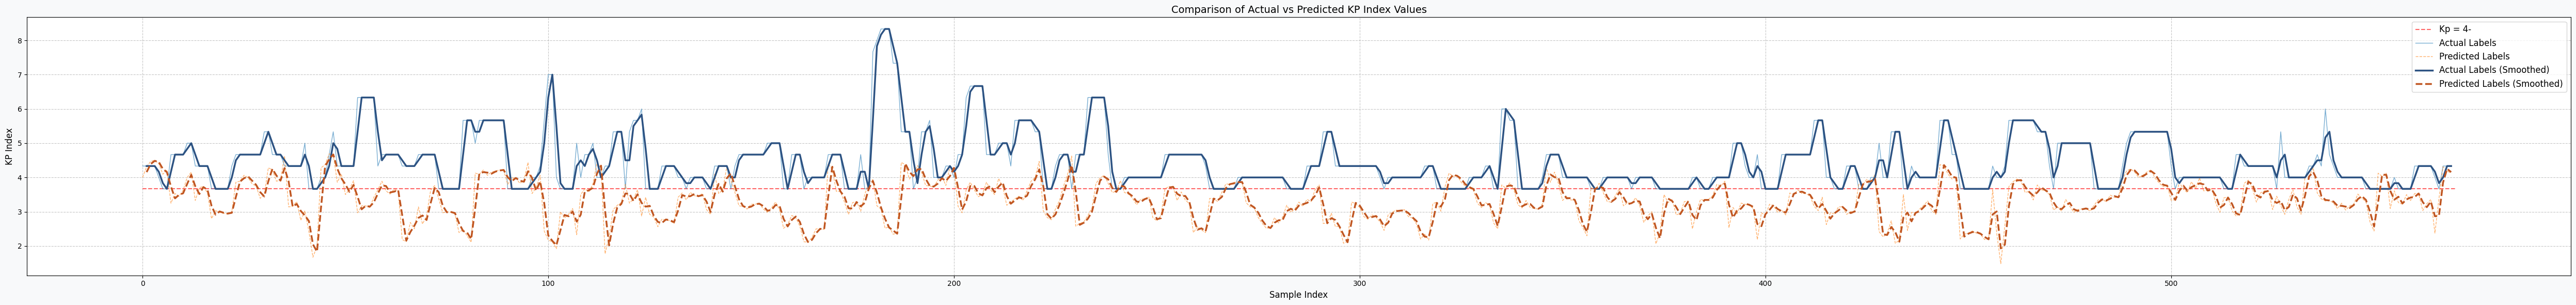

[np.float32(4.0), np.float32(4.3125), np.float32(4.46875), np.float32(4.5), np.float32(4.40625), np.float32(4.09375), np.float32(4.21875), np.float32(3.25), np.float32(3.53125), np.float32(3.453125), np.float32(3.625), np.float32(4.0), np.float32(4.15625), np.float32(3.328125), np.float32(3.703125), np.float32(3.734375), np.float32(3.546875), np.float32(2.796875), np.float32(3.03125), np.float32(2.984375), np.float32(2.953125), np.float32(2.9375), np.float32(3.0), np.float32(3.859375), np.float32(3.890625), np.float32(4.0625), np.float32(4.0), np.float32(3.8125), np.float32(3.75), np.float32(3.390625), np.float32(3.5), np.float32(4.28125), np.float32(4.21875), np.float32(3.890625), np.float32(3.921875), np.float32(4.625), np.float32(3.140625), np.float32(3.15625), np.float32(3.296875), np.float32(2.75), np.float32(3.03125), np.float32(2.421875), np.float32(1.671875), np.float32(2.0), np.float32(4.28125), np.float32(4.375), np.float32(4.6875), np.float32(4.65625), np.float32(3.859375), 

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.1590822843732207


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.1069806064266057


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.627996115218232


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.1633610604752398


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.2601781939696293


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.1848468281896756


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.9144309312528187


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.0599487214790064


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6669367950335674


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.0867139214952202


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5409435179865475


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.283345249000281


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.43979793811579576


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.243179042843994


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.35719622834607


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2345911038240265


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.31115900234694316


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.133038415585204


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2660601777379123


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2045300742717866


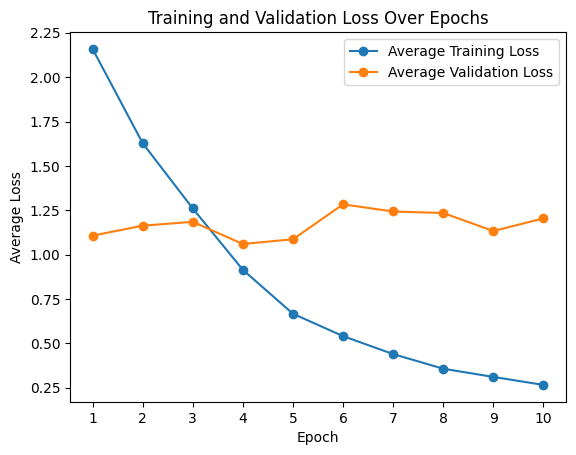

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.2045
RMSE: 1.0975
MSE: 1.2049
MAE: 0.8467
R²: -0.0341
R: 0.3099
True Skill Score: 0.3428
Accuracy: 0.8287
Precision: 0.3814
Recall: 0.1263
F1 Score: 0.1897


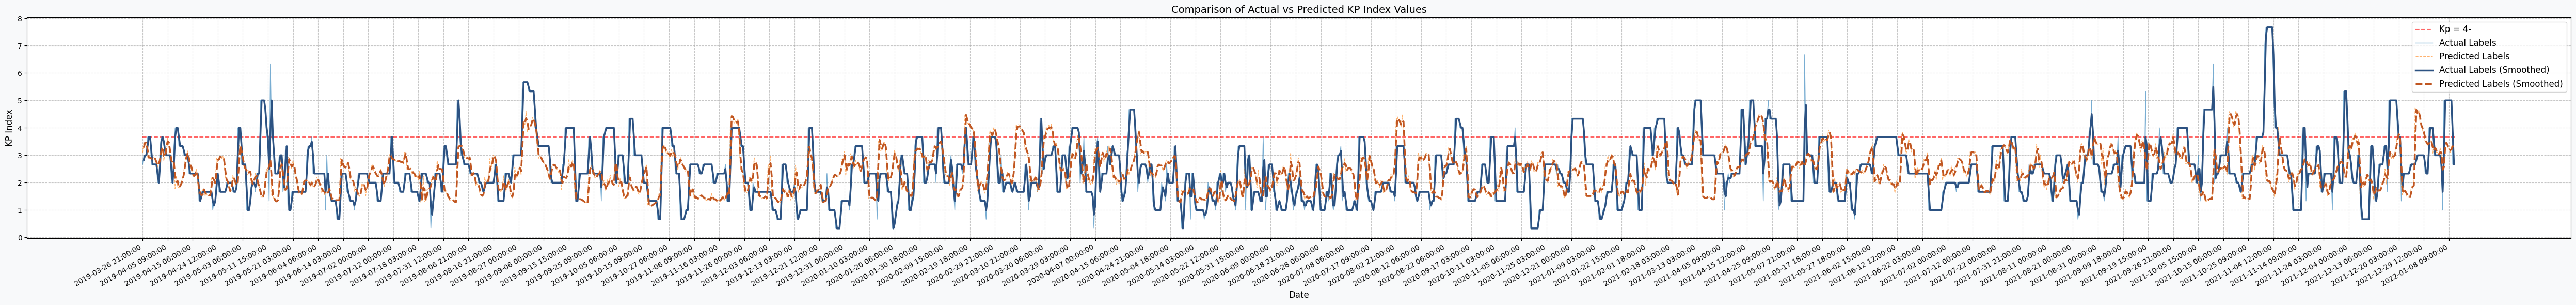

[np.float32(3.09375), np.float32(3.46875), np.float32(3.453125), np.float32(3.46875), np.float32(2.9375), np.float32(2.890625), np.float32(2.9375), np.float32(2.828125), np.float32(2.921875), np.float32(2.9375), np.float32(2.8125), np.float32(2.71875), np.float32(2.5625), np.float32(2.78125), np.float32(2.9375), np.float32(3.40625), np.float32(3.15625), np.float32(2.796875), np.float32(3.125), np.float32(3.375), np.float32(3.640625), np.float32(3.296875), np.float32(3.015625), np.float32(2.609375), np.float32(2.8125), np.float32(2.671875), np.float32(1.78125), np.float32(2.265625), np.float32(1.8515625), np.float32(1.8046875), np.float32(1.9453125), np.float32(2.0), np.float32(2.1875), np.float32(2.453125), np.float32(2.84375), np.float32(3.015625), np.float32(3.15625), np.float32(2.640625), np.float32(2.671875), np.float32(2.46875), np.float32(2.265625), np.float32(2.21875), np.float32(2.359375), np.float32(2.484375), np.float32(1.9765625), np.float32(1.5546875), np.float32(1.6875), n

Testing Progress:   0%|          | 0/147 [00:00<?, ?it/s]

Average test loss: 3.3098
RMSE: 1.8193
MSE: 3.3179
MAE: 1.4988
R²: -4.6816
R: -0.0140


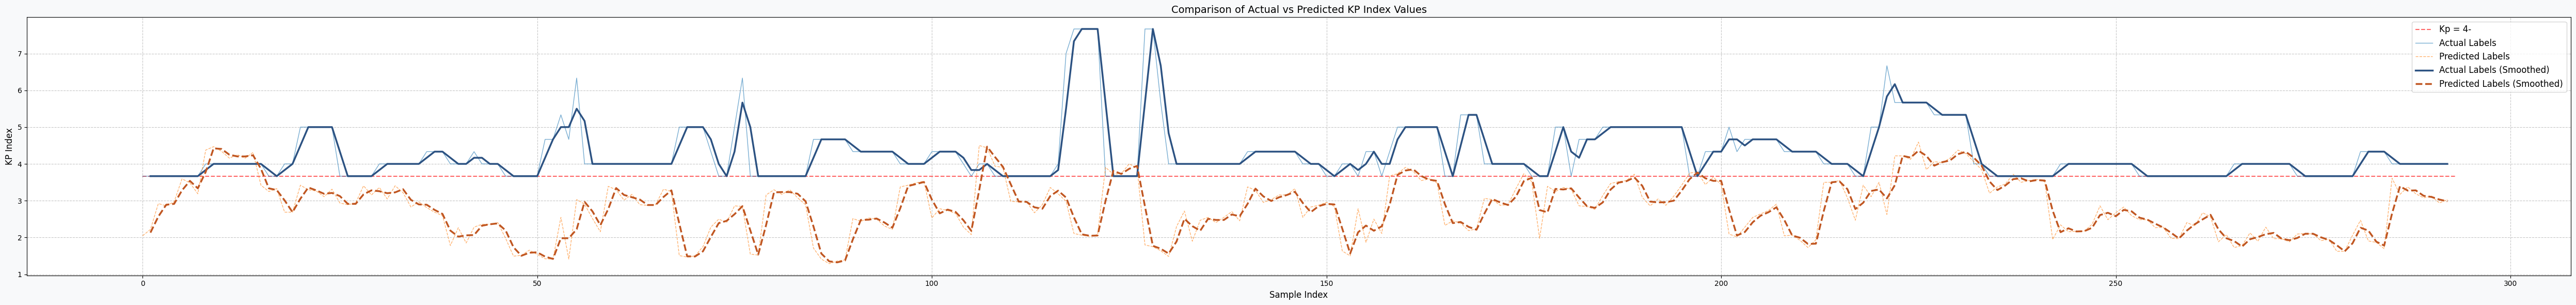

[np.float32(2.046875), np.float32(2.21875), np.float32(2.921875), np.float32(2.859375), np.float32(2.96875), np.float32(3.59375), np.float32(3.484375), np.float32(3.1875), np.float32(4.375), np.float32(4.46875), np.float32(4.34375), np.float32(4.15625), np.float32(4.25), np.float32(4.15625), np.float32(4.3125), np.float32(3.421875), np.float32(3.25), np.float32(3.328125), np.float32(2.6875), np.float32(2.6875), np.float32(3.421875), np.float32(3.296875), np.float32(3.265625), np.float32(3.109375), np.float32(3.3125), np.float32(2.9375), np.float32(2.890625), np.float32(2.9375), np.float32(3.40625), np.float32(3.15625), np.float32(3.359375), np.float32(3.046875), np.float32(3.40625), np.float32(3.21875), np.float32(2.828125), np.float32(2.96875), np.float32(2.8125), np.float32(2.6875), np.float32(2.59375), np.float32(1.78125), np.float32(2.265625), np.float32(1.8515625), np.float32(2.28125), np.float32(2.359375), np.float32(2.359375), np.float32(2.40625), np.float32(1.9765625), np.float

Training Progress: Epoch: 1:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.8565878090005143


Validation Progress: Epoch: 1:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.612972904718837


Training Progress: Epoch: 2:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.3554289583371644


Validation Progress: Epoch: 2:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.4603914013522057


Training Progress: Epoch: 3:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.0596501794986557


Validation Progress: Epoch: 3:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.4216159890943385


Training Progress: Epoch: 4:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.8065728130518287


Validation Progress: Epoch: 4:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  3.1616406131758525


Training Progress: Epoch: 5:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.6307074391000358


Validation Progress: Epoch: 5:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.7632274830677304


Training Progress: Epoch: 6:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.48213788492428716


Validation Progress: Epoch: 6:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.9375536576202976


Training Progress: Epoch: 7:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.4011491053682971


Validation Progress: Epoch: 7:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.8310193690725947


Training Progress: Epoch: 8:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.3485639555856127


Validation Progress: Epoch: 8:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.961918989190201


Training Progress: Epoch: 9:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.3036579282576017


Validation Progress: Epoch: 9:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.5842814101921157


Training Progress: Epoch: 10:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.2683784804606609


Validation Progress: Epoch: 10:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.6269110290635362


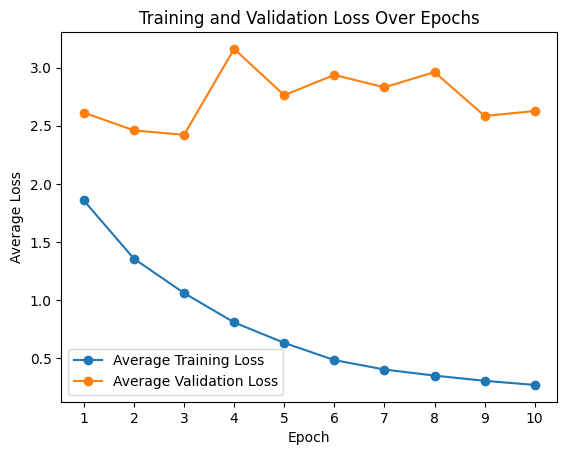

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/936 [00:00<?, ?it/s]

Average test loss: 2.6269
RMSE: 1.6208
MSE: 2.6269
MAE: 1.2426
R²: -0.3694
R: 0.0339
True Skill Score: 0.3267
Accuracy: 0.6058
Precision: 0.4671
Recall: 0.1978
F1 Score: 0.2779


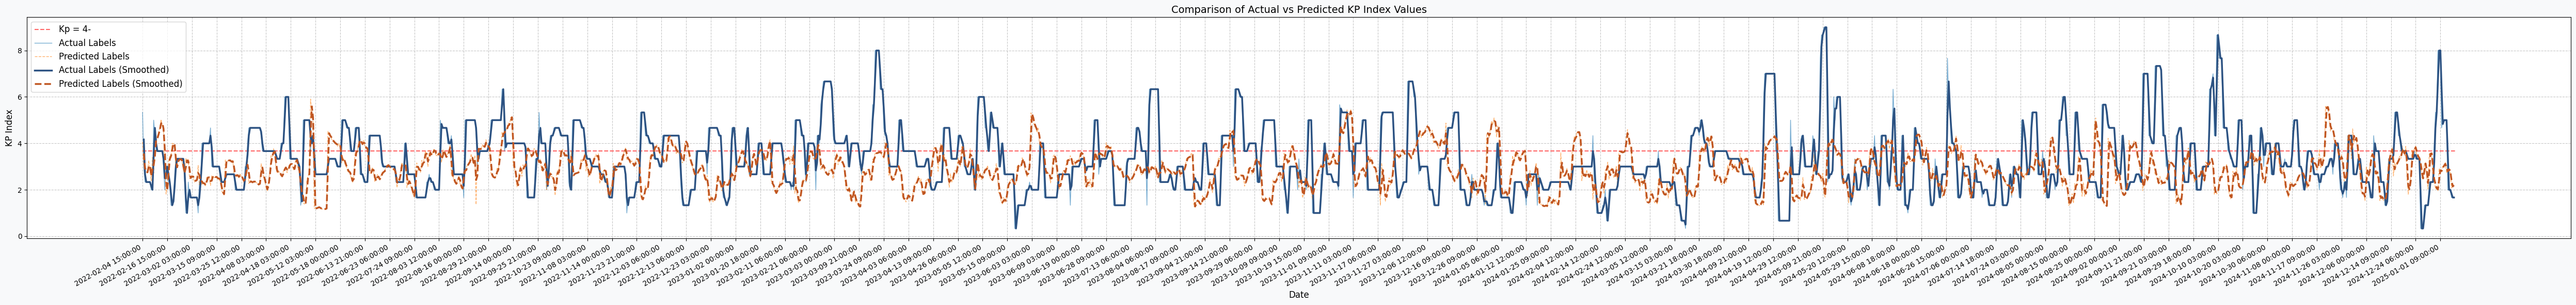

[np.float32(4.0625), np.float32(3.0625), np.float32(2.8125), np.float32(2.765625), np.float32(2.734375), np.float32(3.265625), np.float32(2.8125), np.float32(2.390625), np.float32(3.390625), np.float32(2.71875), np.float32(4.1875), np.float32(4.09375), np.float32(4.3125), np.float32(4.46875), np.float32(4.6875), np.float32(5.03125), np.float32(4.75), np.float32(4.5), np.float32(2.984375), np.float32(1.8125), np.float32(2.140625), np.float32(3.1875), np.float32(3.4375), np.float32(3.453125), np.float32(4.0), np.float32(3.984375), np.float32(3.875), np.float32(2.78125), np.float32(3.15625), np.float32(3.3125), np.float32(3.296875), np.float32(3.34375), np.float32(3.171875), np.float32(2.90625), np.float32(2.546875), np.float32(3.359375), np.float32(3.171875), np.float32(3.3125), np.float32(2.484375), np.float32(2.53125), np.float32(2.609375), np.float32(2.53125), np.float32(2.328125), np.float32(2.4375), np.float32(2.40625), np.float32(3.046875), np.float32(2.21875), np.float32(2.5), np.

Testing Progress:   0%|          | 0/359 [00:00<?, ?it/s]

Average test loss: 4.9334
RMSE: 2.2211
MSE: 4.9334
MAE: 1.8361
R²: -3.6659
R: -0.0772


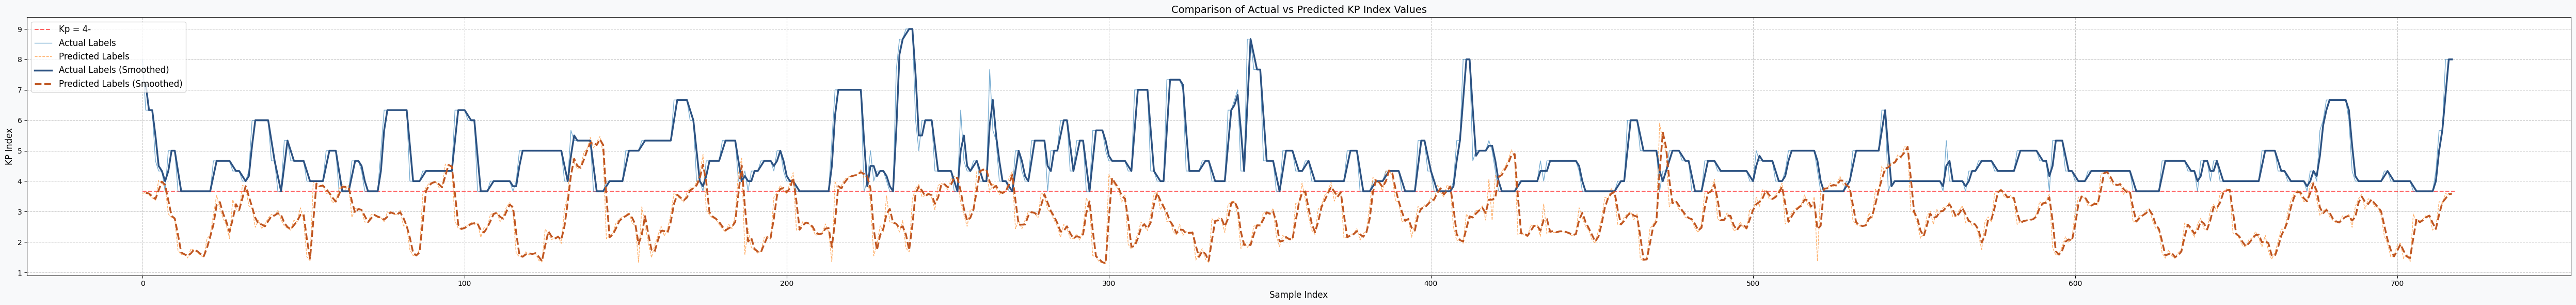

[np.float32(3.59375), np.float32(3.640625), np.float32(3.546875), np.float32(3.453125), np.float32(3.375), np.float32(4.03125), np.float32(3.9375), np.float32(3.8125), np.float32(2.921875), np.float32(2.796875), np.float32(2.75), np.float32(1.7265625), np.float32(1.5859375), np.float32(1.609375), np.float32(1.4765625), np.float32(1.7734375), np.float32(1.734375), np.float32(1.65625), np.float32(1.5625), np.float32(1.5), np.float32(2.109375), np.float32(2.234375), np.float32(2.90625), np.float32(3.53125), np.float32(3.09375), np.float32(2.78125), np.float32(2.5625), np.float32(2.109375), np.float32(3.390625), np.float32(3.09375), np.float32(3.015625), np.float32(3.859375), np.float32(3.8125), np.float32(3.1875), np.float32(3.109375), np.float32(2.484375), np.float32(2.71875), np.float32(2.4375), np.float32(2.59375), np.float32(2.78125), np.float32(2.90625), np.float32(2.84375), np.float32(3.046875), np.float32(2.734375), np.float32(2.53125), np.float32(2.453125), np.float32(2.390625), n

In [23]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [24]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
